# Chapter 2 Exercises

## Table of Contents

- [Preparation](#preparation)
- [Exercise 1](#ex1)

In [41]:
# Pydata stack
import numpy as np
import pandas as pd
import scipy

from matplotlib import pyplot as plt

# Scikit-Learn
from sklearn.model_selection import StratifiedShuffleSplit # To split into train/test set
from sklearn.base import BaseEstimator, TransformerMixin # To create custom transformers
from sklearn.impute import SimpleImputer # To handle missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Feature scaling and dealing with categorical
from sklearn.pipeline import Pipeline # Pipelines to chain estimators
from sklearn.compose import ColumnTransformer # To apply different transformers to different columns
from sklearn.metrics import mean_squared_error # Metrics

# Models
from sklearn.svm import SVR # Support vector machine regressor

# Cross validation/hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Display HTML representation of composite estimators
from sklearn import set_config 
set_config(display='diagram')  

# Miscellaneous packages
import os # For OS dependent functionality
from time import perf_counter # To measure performance
import joblib # To save arbitrary Python objects (e.g. models)

## Preparation <a name="preparation"></a>

These exercises are based on the housing example project so require some set up.

Begin by loading the data.

In [2]:
HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)


housing = load_housing_data()

Now create a test set using stratified sampling on median income as a categorical variable.

In [3]:
# Turn median income from continuous to categorical variable
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Create split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# Remove new categorical variable
for df in [strat_train_set, strat_test_set]:
    df.drop('income_cat', axis=1, inplace=True)

Now some data cleaning.

In [4]:
# Get a clean copy of training set and separate into inputs and outputs
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

# Split training set into categorical and numerical attributes
housing_cat = housing[['ocean_proximity']]
housing_num = housing.drop('ocean_proximity', axis=1)

cat_attribs = ["ocean_proximity"]
num_attribs = list(housing_num)

We want a custom transformer to add additional columns.

In [5]:
# Column indices since you need to input and output numpy arrays
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):       
        return self
    
    def transform(self, X):   
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

Now create pipeline for data preparation

In [6]:
# Pipeline for numerical inputs
estimators = [
    ('imputer', SimpleImputer(strategy="median")), # (name, estimator) pairs
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
]
num_pipeline = Pipeline(estimators)

# Combine numerical and categorical pipelines
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Prepare data
housing_prepared = full_pipeline.fit_transform(housing)

## Exercise 1 <a name="ex1"></a>

Try a Support Vector Machine regressor (`sklearn.svm.SVR`) with various hyperparameters, such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

### Solution



Start with all hyperparameters taking default values

In [34]:
svr = SVR()
svr.fit(housing_prepared, housing_labels)

svr_predictions = svr.predict(housing_prepared)
svr_rmse = mean_squared_error(svr_predictions, housing_labels, squared=False)
print('Support Vector Regressor RMSE: {:0.0f}'.format(svr_rmse))

Support Vector Regressor RMSE: 118581


The base error rate was 115700 so we are definitely underfitting.

Let's try again with a grid search. I've saved the result of the grid search as a `.pkl` file as it takes a while to run. If such a file exists, the following function will just load it rather than rerunning the search.

In [27]:
MODELS_FOLDER = 'models'

def perform_svr_grid_search(models_folder=MODELS_FOLDER):
    '''
    Loads grid_search from 'models_folder/svr-grid-search.pkl' if it exists,
    otherwise performs SVR grid search and saves to this path. Note that 
    running the grid search takes about 15 minutes.
    '''
    grid_search_path = os.path.join(models_folder, 'svr-grid-search.pkl')
    
    if os.path.isfile(grid_search_path):
        grid_search = joblib.load(grid_search_path)
        print('Grid search loaded from ' + grid_search_path)
        return grid_search
    
    else:       
        # Initialise model
        svr = SVR()

        # Set params to try
        param_grid = [
            {'kernel': ['linear'], 'C': [0.1, 0.3, 1, 3, 10]},
            {'kernel': ['rbf'], 'C': [0.3, 1, 3], 'gamma': ['scale', 'auto']}
        ]

        # Initialise grid search
        grid_search = GridSearchCV(
            svr,
            param_grid,
            scoring='neg_root_mean_squared_error',
            cv=5,
            return_train_score=True,
            refit=True
        )

        # Perform search
        start_time = perf_counter()
        grid_search.fit(housing_prepared, housing_labels)
        end_time = perf_counter()
        print('Grid search run time: {:0.1f} seconds'.format(end_time - start_time))

        # Save output
        joblib.dump(grid_search, grid_search_path)
        
        return grid_search


grid_search = perform_svr_grid_search()

Show a summary of the results

In [33]:
# This is just a utility function
def get_param_from_dict(dict, param_name, param_default=None):
    'Use with .apply() to get series of parameter values from series of params dicts'
    if dict.get(param_name) is not None:
        return dict.get(param_name)
    else:
        return param_default


# Get results
cv_res = grid_search.cv_results_
cv_res_summary = pd.DataFrame(
    {
        'params' : cv_res['params'], 
        'mean_test_score' : cv_res['mean_test_score'],
        'mean_train_score' : cv_res['mean_train_score'],
    }
)

# Make test scores positive and round them
cv_res_summary[['mean_test_score', 'mean_train_score']] = -cv_res_summary[['mean_test_score', 'mean_train_score']].astype(int)

# Split params column into individual parameter values
param_defaults = {
    'kernel': 'rbf',
    'C': 1.0,
    'gamma': 'scale'
}
for key, value in param_defaults.items():
    col_name = key + '_param'
    cv_res_summary[col_name] = cv_res_summary['params'].apply(
        lambda dict: get_param_from_dict(dict, param_name=key, param_default=value)
    )    

# Clean up
cv_res_summary.drop(columns='params', inplace=True)
cv_res_summary = cv_res_summary.sort_values('mean_test_score', ascending=True).reset_index(drop=True)

# Show results
cv_res_summary

,mean_test_score,mean_train_score,kernel_param,C_param,gamma_param
0,84641,84614,linear,10.0,scale
1,102386,102369,linear,3.0,scale
2,112560,112548,linear,1.0,scale
3,116890,116885,linear,0.3,scale
4,118052,118049,rbf,3.0,scale
5,118064,118060,rbf,3.0,auto
6,118237,118234,linear,0.1,scale
7,118620,118617,rbf,1.0,scale
8,118623,118620,rbf,1.0,auto
9,118821,118820,rbf,0.3,scale


The models underperform both the ordinary least squares and random forest regressors, but since the maximum value of `C` yielded by far the lowest mean test score we can probably improve performance by tuning the hyperparameters. Indeed, since the test and train scores are so similar, we are probably underfitting the model. This fits with the fact that `C` is the regularisation parrameter and is inversely proportional to the strength of the regularisation: increasing `C` should reduce underfitting.

## Exercise 2 <a name="ex2"></a>

Try replacing `GridSearchCV` with `RandomizedSearchCV`.

### Solution

As in exercise 1, I'm packaging this in a function to avoid running the randomised search if not necessary.

In [50]:
gamma.ppf(0.01)

0.14855474025326595

''

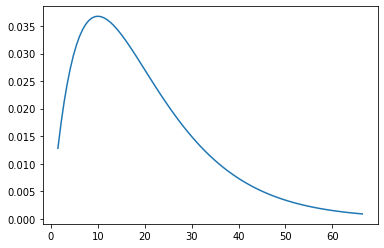

In [70]:
# Create distribution
alpha = 2
beta = .1

gamma = scipy.stats.gamma(a=alpha, scale=1/beta)

# Plot pdf
fig, ax = plt.subplots()

x = np.linspace(gamma.ppf(0.01), gamma.ppf(0.99), 100)
ax.plot(x, gamma.pdf(x))

;

In [71]:
MODELS_FOLDER = 'models'

def perform_svr_random_search(models_folder=MODELS_FOLDER):
    '''
    Loads random_search from 'models_folder/svr-random-search.pkl' if it exists,
    otherwise performs SVR random search and saves to this path. Note that 
    running the random search takes about 15 minutes.
    '''
    random_search_path = os.path.join(models_folder, 'svr-random-search.pkl')
    
    if os.path.isfile(random_search_path):
        random_search = joblib.load(random_search_path)
        print('Random search loaded from ' + random_search_path)
        return random_search
    
    else:       
        # Initialise model
        svr = SVR()
        
        # Set parameter distributions
        alpha = 2
        beta = .1
        gamma = scipy.stats.gamma(a=alpha, scale=1/beta)

        param_distributions = {
            'kernel': ['linear', 'rbf'],
            'C': gamma
        }

        # Initialise random search
        random_search = RandomizedSearchCV(
            svr,
            param_distributions,
            n_iter=10,
            scoring='neg_root_mean_squared_error',
            cv=5,
            return_train_score=True,
            refit=True
        )

        # Perform search
        start_time = perf_counter()
        random_search.fit(housing_prepared, housing_labels)
        end_time = perf_counter()
        print('Randomised search run time: {:0.1f} seconds'.format(end_time - start_time))

        # Save output
        joblib.dump(random_search, random_search_path)
        
        return random_search


random_search = perform_svr_random_search()

Randomised search run time: 1045.2 seconds


Now let's show a summary of the results.

In [75]:
# This is just a utility function
def get_param_from_dict(dict, param_name, param_default=None):
    'Use with .apply() to get series of parameter values from series of params dicts'
    if dict.get(param_name) is not None:
        return dict.get(param_name)
    else:
        return param_default


# Get results
cv_res = random_search.cv_results_
cv_res_summary = pd.DataFrame(
    {
        'params' : cv_res['params'], 
        'mean_test_score' : cv_res['mean_test_score'],
        'mean_train_score' : cv_res['mean_train_score'],
    }
)

# Make test scores positive and round them
cv_res_summary[['mean_test_score', 'mean_train_score']] = -cv_res_summary[['mean_test_score', 'mean_train_score']].astype(int)

# Split params column into individual parameter values
param_defaults = {
    'kernel': 'rbf',
    'C': 1.0,
}
for key, value in param_defaults.items():
    col_name = key + '_param'
    cv_res_summary[col_name] = cv_res_summary['params'].apply(
        lambda dict: get_param_from_dict(dict, param_name=key, param_default=value)
    )    

# Clean up
cv_res_summary.drop(columns='params', inplace=True)
cv_res_summary = cv_res_summary.sort_values('mean_test_score', ascending=True).reset_index(drop=True)

# Show results
cv_res_summary

,mean_test_score,mean_train_score,kernel_param,C_param
0,76003,75968,linear,26.904937
1,76358,76323,linear,25.141598
2,80210,80183,linear,15.670196
3,101010,100988,rbf,79.884463
4,113251,113241,rbf,20.932381
5,113294,113284,rbf,20.771611
6,113787,113776,rbf,18.899922
7,114427,114418,rbf,16.363983
8,116719,116715,rbf,7.825699
9,117319,117317,rbf,5.641006


This is an improvement on the grid search, but this is primarily because we allowed the `C` parameter to vary over larger values. The results suggest that the model is still underfitting and we need to explore higher values of `C`.